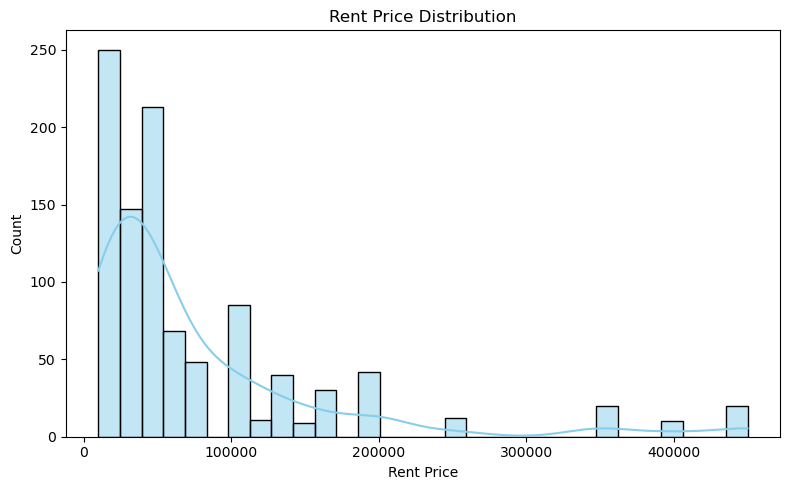

C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['private_washroom' 'public_washroom']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['electric_charge_included' 'water_charge_included']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


RMSE: 10197.40
MAE: 1304.66
R2 Score: 0.95
Predicted Commercial Rent: ₹39920.0


C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['private_washroom' 'public_washroom']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['electric_charge_included' 'water_charge_included']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['private_washroom' 'public_washroom']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features witho

In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sys
import os
sys.path.append(os.path.abspath('app'))
from app.utils import map_yes_no_to_bool


# Load Dataset
df = pd.read_csv('commercial_data.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Rename columns

df.rename(columns={
    'security_deposite': 'security_deposit',
    'expected_rent_increases_yearly': 'rent_increase_per_year'
}, inplace=True)

# Drop irrelevant columns if present
drop_cols = ['listing_title', 'lock_in_period', 'listing_litle', 'security_deposit']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Data Cleaning
df['size_in_sqft'] = df['size_in_sqft'].astype(str).str.extract(r'(\d+)').astype(float)
df['carpet_area_sqft'] = df['carpet_area_sqft'].astype(str).str.extract(r'(\d+)').astype(float)
df['total_floors'] = df['total_floors'].astype(str).str.extract(r'(\d+)').astype(float)

# Fill boolean-like columns with False for missing values
df.fillna({
    'private_washroom': False,
    'public_washroom': False,
    'electric_charge_included': False,
    'water_charge_included': False
}, inplace=True)

# Fill missing values in numeric column
df['total_floors'] = df['total_floors'].fillna(df['total_floors'].median())

# Visualize Rent Price Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['rent_price'], kde=True, bins=30, color='skyblue')
plt.title('Rent Price Distribution')
plt.xlabel('Rent Price')
plt.tight_layout()
plt.show()

# Removing outliers based on IQR
Q1 = df['rent_price'].quantile(0.25)
Q3 = df['rent_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['rent_price'] >= lower_bound) & (df['rent_price'] <= upper_bound)]

# Feature Engineering
df['amenities_count'] = df['amenities_count'].fillna('').apply(lambda x: len(str(x).split(',')))

# Identify features and target
target = 'rent_price'
X = df.drop(columns=[target])
y = df[target]


# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
yes_no_bool_transformer = FunctionTransformer(map_yes_no_to_bool)
# Full pipeline with Yes/No transformer
model_pipeline = Pipeline(steps=[
    ('yes_no_mapper', yes_no_bool_transformer),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

model_bundle = joblib.load("app/model/commercial_rent_model.pkl")

# Save the model
joblib.dump(model_pipeline, 'commercial_rent_model.pkl')

# Load the model and predict new sample
model_pipeline = joblib.load("commercial_rent_model.pkl")

new_data = pd.DataFrame([{
    'city': 'nagpur',
    'area': 'manewada',
    'location': 'manewada,nagpur',
    'zone': 'south',
    'location_hub': 'Tech Park',
    'property_type': 'Office Space',
    'ownership': 'Freehold',
    'size_in_sqft': 1200.0,
    'carpet_area_sqft': 1000.0,
    'private_washroom': 'Yes',
    'public_washroom': 'Yes',
    'floor_no': '5th',
    'total_floors': '10',
    'amenities_count': 5,
    'electric_charge_included': 'Yes',
    'water_charge_included': 'Yes',
    'property_age': '5-10 years',
    'possession_status': 'Immediate',
    'posted_by': 'Owner',
    'rent_increase_per_year': '5%',
    'negotiable': 'Yes',
    'brokerage': 'No'
}])

predicted_rent = model_pipeline.predict(new_data)[0]
print(f"Predicted Commercial Rent: ₹{round(predicted_rent, 2)}")


In [2]:
new_data = pd.DataFrame([{
    'city': 'nagpur',
    'area': 'manewada',
    'location': 'manewada,nagpur',
    'zone': 'south',
    'location_hub': 'Tech Park',
    'property_type': 'shop',
    'ownership': 'Freehold',
    'size_in_sqft': 250.0,
    'carpet_area_sqft': 200.0,
    'private_washroom': 'Yes',
    'public_washroom': 'Yes',
    'floor_no': '5th',
    'total_floors': '10',
    'amenities_count': 5,
    'electric_charge_included': 'Yes',
    'water_charge_included': 'Yes',
    'property_age': '5-10 years',
    'possession_status': 'Immediate',
    'posted_by': 'Owner',
    'rent_increase_per_year': '5%',
    'negotiable': 'Yes',
    'brokerage': 'No'
}])

predicted_rent = model_pipeline.predict(new_data)[0]
print(f"Predicted Commercial Rent: ₹{round(predicted_rent, 2)}")


Predicted Commercial Rent: ₹22180.0


C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['private_washroom' 'public_washroom']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\HP\.conda\envs\rental_price_env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['electric_charge_included' 'water_charge_included']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
